<a href="https://colab.research.google.com/github/hugoalfedoputra-ub/ml/blob/main/nn_course/T1/Tugas_1_PyTorch_Backprop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modifikasi Neural Network oleh yunjey dalam Mempelajari Backpropagation dengan PyTorch

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
input_size = 784
hidden_size = 500
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='../../data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data',
                                          train=False,
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

# Pengaturan Hyper-parameter

```py
# Hyper-parameters
input_size = 784; hidden_size = 500; num_classes = 10; num_epochs = 5; batch_size = 100; learning_rate = 0.001
```

Cuplikan di atas menunjukkan enam hyper-parameter yang digunakan, yaitu:

1. `input_size`: banyak neuron input pada jaringan. Perlu diketahui, berdasarkan LeCun pada [situs ini](https://yann.lecun.com/exdb/mnist/):

```
.... the images were centered in a 28x28 image by computing the center of mass of the pixels, ...
```

bahwa gambar-gambar pada dataset MNIST memiliki ukuran 28 pixel kali 28 pixel, sehingga tiap neuron input berupa tiap pixel ($28\text{px}\times 28\text{px}=784\text{px}$) pada gambar dari dataset tersebut.

2. `hidden_size`: banyak neuron pada satu lapisan tersembunyi pada jaringan
3. `num_classes`: banyak kelas kategori yang akan diklasifikasikan oleh jaringan; bernilai 10 karena dataset gambar berupa tiap digit dari 0 hingga 9
4. `num_epochs`: di mana epoch sendiri berarti satu putaran pada dataset; sehingga `num_epochs` berarti banyak putaran pada dataset yang akan dilakukan saat proses training
5. `batch_size`: besar sample dari dataset yang akan digunakan dalam satu iterasi dalam satu epoch, di mana dari hasil:

```py
print('Train dataset size: ', len(train_dataset))
...

Train dataset size:  60000
test dataset size:  10000
Loaded train size:  600
Loaded test size:  100
```

terlihat bahwa `batch_size = 100` berarti akan terdapat (dalam kasus dataset training) $60000\div 100 = 600$ iterasi di mana tiap iterasi berisi 100 sample dari dataset.

6. `learning_rate`: seberapa besar (atau jauh) bobot akan berubah setelah jaringan melalui optimasi untuk meminimalisir loss

## Deklarasi Hyper-parameter untuk Eksperimen

```py
# Hyper-parameters
input_size = 784 # tetap sama
num_classes = 10 # tetap sama
hidden_size = [400, 500, 600]
hidden_layers = [1, 2, 3]
max_epochs = range(3,10,2) # sama dengan num_epochs: 3, 5, 7, 9
batch_size = [100, 300, 600]
learning_rate = [10e-2, 10e-3, 10e-4]
```

Eksperimen menggunakan [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) dengan kombinasi parameter yang dilatih sebanyak 15 dan cross-validation sebesar 5.

# Melihat seberapa besar train dan test dataset

In [2]:
print('Train dataset size: ', len(train_dataset))
print('test dataset size: ', len(test_dataset))
print('Loaded train size: ', len(train_loader))
print('Loaded test size: ', len(test_loader))

Train dataset size:  60000
test dataset size:  10000
Loaded train size:  600
Loaded test size:  100


# Kelas NeuralNet oleh yunjey

In [3]:
import matplotlib.pyplot as plt

# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(NeuralNet, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    out = self.fc1(x)
    out = self.relu(out)
    out = self.fc2(out)
    return out

## Forward Pass

```py
def forward(self, x):
    out = self.fc1(x)
    out = self.relu(out)
    out = self.fc2(out)
    return out
```

merupakan fungsi milik kelas `NeuralNet` bernama `forward` yang merupakan forward-pass pada jaringan. Tahapan forward-pass dirincikan:

1. Variabel `out` pertama merupakan weighted sum (matriks $784\times1$) dari FC layer pertama,
2. Variabel `out` kedua menerapkan fungsi aktivasi ReLU pada tiap baris pada matriks weighted sum, lalu
3. Variabel `out` terakhir mengembalikan weighted sum (matriks $500\times1$) dari FC layer kedua yang kemudian di-`return`.

Nantinya pada kode, forward pass dilakukan pada

```py
# Forward pass
outputs = model(images)
loss = criterion(outputs, labels)
```

saat melatih model.

# Pelatihan model yunjey


In [4]:
model = NeuralNet(input_size, hidden_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
losses = []
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    # Move tensors to the configured device
    images = images.reshape(-1, 28*28).to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if (i+1) % 100 == 0:
      print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
              .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
    images = images.reshape(-1, 28*28).to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

Epoch [1/5], Step [100/600], Loss: 0.3231
Epoch [1/5], Step [200/600], Loss: 0.2250
Epoch [1/5], Step [300/600], Loss: 0.3713
Epoch [1/5], Step [400/600], Loss: 0.1668
Epoch [1/5], Step [500/600], Loss: 0.1718
Epoch [1/5], Step [600/600], Loss: 0.2156
Epoch [2/5], Step [100/600], Loss: 0.1390
Epoch [2/5], Step [200/600], Loss: 0.1133
Epoch [2/5], Step [300/600], Loss: 0.0479
Epoch [2/5], Step [400/600], Loss: 0.1742
Epoch [2/5], Step [500/600], Loss: 0.0365
Epoch [2/5], Step [600/600], Loss: 0.0750
Epoch [3/5], Step [100/600], Loss: 0.0717
Epoch [3/5], Step [200/600], Loss: 0.0443
Epoch [3/5], Step [300/600], Loss: 0.0163
Epoch [3/5], Step [400/600], Loss: 0.0851
Epoch [3/5], Step [500/600], Loss: 0.0526
Epoch [3/5], Step [600/600], Loss: 0.0678
Epoch [4/5], Step [100/600], Loss: 0.0399
Epoch [4/5], Step [200/600], Loss: 0.0972
Epoch [4/5], Step [300/600], Loss: 0.0549
Epoch [4/5], Step [400/600], Loss: 0.0918
Epoch [4/5], Step [500/600], Loss: 0.0378
Epoch [4/5], Step [600/600], Loss:

## Melatih Model

```py
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        ...
```

Pada cuplikan di atas terlihat dalam pelatihan model, tiap gambar (dalam kasus ini berupa tensor 2D $28\times28$) diubah menjadi tensor 1D dengan panjang 784 (sama dengan `28*28`) pada `images = images.reshape(-1, 28*28).to(device)` khususnya dengan argumen `-1` pada `reshape(-1, ...`. Tiap label juga diteruskan ke device atau ke jaringan dengan `labels = labels.to(device)`.

## Penghitungan Loss

Seperti pada

```
criterion = nn.CrossEntropyLoss()
```

di mana jaringan menggunakan [Cross Entropy Loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) yang berfungsi dengan menghitung perbedaan distribusi probabilitas antara model dan prediksinya (Sumber: [Datacamp](https://www.datacamp.com/tutorial/the-cross-entropy-loss-function-in-machine-learning)).

## Optimasi

Seperti pada

```
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
```

di mana jaringan menggunakan optimasi ADAM (Adaptive Moment Estimation) yang akan mengatur nilai `learning_rate` secara dinamis agar nilai tersebut mengalami perubahan besar saat di awal dan mengecil (secara eksponensial) di akhir (Sumber: [GeeksForGeeks](https://www.geeksforgeeks.org/adam-optimizer/)).

## Backward Pass

```py
# Backward and optimize
optimizer.zero_grad()
loss.backward()
optimizer.step()

if (i+1) % 100 == 0:
    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
            .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
```

Pada cuplikan di atas terlihat optimasi dan backpropagation (backward pass). Mulanya, nilai-nilai gradien dibuat `null` (berdasarkan [docs ini](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html)) yang kemudian dihitung loss-nya dan kemudian dilakukan backpropagation dengan `loss.backward()`. Terakhir dilakukan `optimizer.step()` untuk melakukan satu step (iterasi) optimasi (berdasarkan [docs ini](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.step.html)). Hanya tiap 100 step akan di-print ke console beserta nilai loss-nya sebagaimana terlihat pada

```py
Epoch [1/5], Step [100/600], Loss: 0.3124
Epoch [1/5], Step [200/600], Loss: 0.1915
Epoch [1/5], Step [300/600], Loss: 0.2400
...
```

# Plotting penghitungan loss dari model contoh oleh yunjey

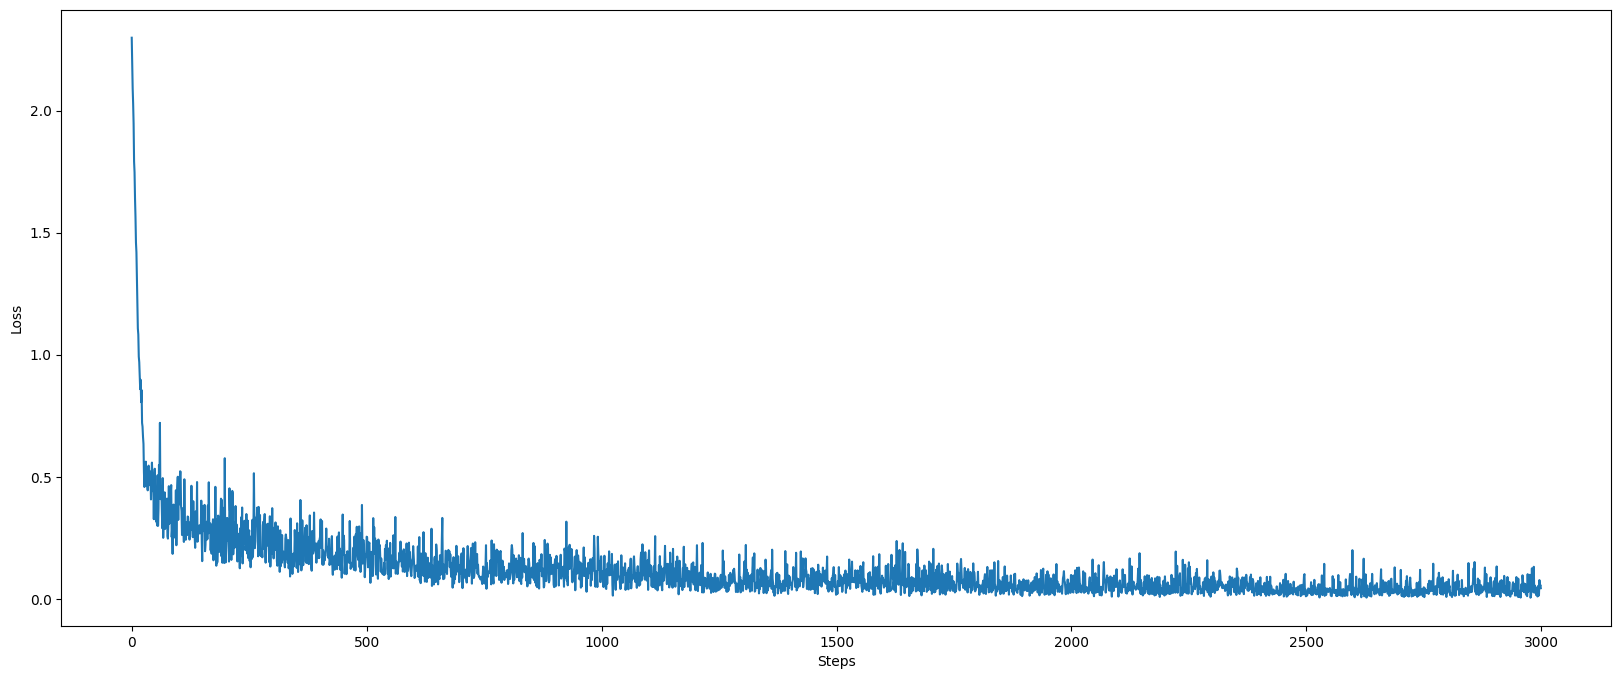

In [5]:
# Plotting penghitungan loss dari model contoh oleh yunjey
plt.figure(figsize=(20,8))
plt.plot(range(3000), losses)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

# Kelas MyNet (modifikasi NeuralNet)

In [6]:
# !pip install -U "ray[tune]" --quiet
!pip install skorch --quiet

In [79]:
# Ini adalah kelas neural network yang dapat menerima parameter banyak hidden layer, besar
# hidden layer tersebut (dianggap sama untuk semua), satu fungsi aktivasi untuk neuron input
# dan hidden layer, dan implementasi softmax untuk neuron output (apabila softmax=True)
class MyNet(nn.Module):
  def __init__(self, input_size, hidden_size, hidden_layers, activation, num_classes, softmax=True):
    super(MyNet, self).__init__()

    layers = []
    layers.append(nn.Linear(input_size, hidden_size))
    layers.append(activation())

    for _ in range(hidden_layers - 2):
      layers.append(nn.Linear(hidden_size, hidden_size))
      layers.append(activation())

    layers.append(nn.Linear(hidden_size, hidden_size))
    if softmax:
      layers.append(nn.Softmax(dim=1))

    layers.append(nn.Linear(hidden_size, num_classes))
    self.layers = nn.Sequential(*layers)

  def forward(self, x):
    return self.layers(x)

# Randomized Search untuk hyper-parameter tuning

Code block ini dapat memakan waktu kurang lebih 70 menit untuk dijalankan dengan CPU yang dialokasikan oleh Google Colab. Hasil dari eksekusi code block ini dirincikan di bagan setelah ini.

In [117]:
from skorch import NeuralNetClassifier
from skorch.dataset import Dataset
from sklearn.model_selection import RandomizedSearchCV

# Deklarasikan X dan y sebagai tensor untuk GridSearchCV
X = torch.cat([data for data, _ in train_dataset], dim=0)
y = torch.tensor(train_dataset.targets)

# Reshape X menjadi (number_of_samples, 784)
X = X.view(X.size(0), -1)

param_grid = {
  "module__hidden_layers": [1, 2, 3],
  "module__hidden_size": [400, 500, 600],
  "max_epochs": range(3, 10, 2),
  "batch_size": [100, 300, 600],
  "lr": [1e-2, 1e-3, 1e-4],
  "module__activation": [nn.ReLU, nn.LeakyReLU, nn.Sigmoid]
}

model = NeuralNetClassifier(
  module=MyNet,
  module__input_size=784,
  module__num_classes=10,
  criterion=nn.CrossEntropyLoss,
  optimizer=torch.optim.Adam,
  verbose=True
)

search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=15, n_jobs=-1, cv=5, verbose=3)
# search_result = search.fit(X, y)

# Hasil RandomizedSearch
print("Best: %f using %s" % (search_result.best_score_, search_result.best_params_))

Best: 0.850250 using {'module__hidden_size': 400, 'module__hidden_layers': 2, 'module__activation': <class 'torch.nn.modules.activation.LeakyReLU'>, 'max_epochs': 3, 'lr': 0.01, 'batch_size': 600}


<ipython-input-117-a728bef592f3>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(train_dataset.targets)


## Hasil Randomized Search
```
Fitting 5 folds for each of 15 candidates, totalling 75 fits
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.7648       0.8130        1.2276  17.4473
      2        0.9048       0.8441        0.6823  15.3841
      3        0.5718       0.8491        0.5248  15.5115
Best: 0.850250 using {'module__hidden_size': 400, 'module__hidden_layers': 2, 'module__activation': <class 'torch.nn.modules.activation.LeakyReLU'>, 'max_epochs': 3, 'lr': 0.01, 'batch_size': 600}
```

In [118]:
from pprint import pprint

# pprint(search_result.cv_results_)

## Hasil `search_results.cv_results_`

```
{'mean_fit_time': array([ 25.76211748, 406.07247658,  32.6550324 , 461.06494341,
        36.48139534,  58.19377413,  86.26021643,  26.14269991,
       108.35000811,  27.34807625,  31.69404082,  48.70340528,
        37.13466001, 135.05869155, 132.57700453]),
 'mean_score_time': array([0.99876261, 1.30301166, 1.08901854, 1.6303412 , 0.89456429,
       0.79002395, 1.22110229, 1.01155925, 1.40828638, 1.11396632,
       1.04843531, 1.11287117, 0.78827968, 1.6097548 , 1.11396928]),
 'mean_test_score': array([0.74038333, 0.8247    , 0.61338333, 0.65378333, 0.65368333,
       0.85025   , 0.6371    , 0.56995   , 0.32498333, 0.46226667,
       0.51238333, 0.72213333, 0.60315   , 0.16885   , 0.61073333]),
 'param_batch_size': masked_array(data=[100, 600, 100, 100, 300, 600, 300, 600, 300, 600, 300,
                   300, 600, 100, 600],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'param_lr': masked_array(data=[0.001, 0.01, 0.0001, 0.001, 0.0001, 0.01, 0.0001,
                   0.001, 0.01, 0.0001, 0.01, 0.01, 0.0001, 0.01, 0.01],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'param_max_epochs': masked_array(data=[3, 7, 3, 9, 7, 3, 9, 3, 7, 3, 3, 5, 7, 5, 9],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'param_module__activation': masked_array(data=[<class 'torch.nn.modules.activation.LeakyReLU'>,
                   <class 'torch.nn.modules.activation.ReLU'>,
                   <class 'torch.nn.modules.activation.ReLU'>,
                   <class 'torch.nn.modules.activation.LeakyReLU'>,
                   <class 'torch.nn.modules.activation.LeakyReLU'>,
                   <class 'torch.nn.modules.activation.LeakyReLU'>,
                   <class 'torch.nn.modules.activation.ReLU'>,
                   <class 'torch.nn.modules.activation.Sigmoid'>,
                   <class 'torch.nn.modules.activation.LeakyReLU'>,
                   <class 'torch.nn.modules.activation.LeakyReLU'>,
                   <class 'torch.nn.modules.activation.Sigmoid'>,
                   <class 'torch.nn.modules.activation.Sigmoid'>,
                   <class 'torch.nn.modules.activation.ReLU'>,
                   <class 'torch.nn.modules.activation.ReLU'>,
                   <class 'torch.nn.modules.activation.ReLU'>],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'param_module__hidden_layers': masked_array(data=[2, 1, 1, 3, 1, 2, 2, 1, 3, 3, 3, 1, 2, 3, 3],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'param_module__hidden_size': masked_array(data=[400, 600, 600, 600, 400, 400, 600, 600, 500, 500, 500,
                   600, 400, 600, 500],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'batch_size': 100,
             'lr': 0.001,
             'max_epochs': 3,
             'module__activation': <class 'torch.nn.modules.activation.LeakyReLU'>,
             'module__hidden_layers': 2,
             'module__hidden_size': 400},
            {'batch_size': 600,
             'lr': 0.01,
             'max_epochs': 7,
             'module__activation': <class 'torch.nn.modules.activation.ReLU'>,
             'module__hidden_layers': 1,
             'module__hidden_size': 600},
            {'batch_size': 100,
             'lr': 0.0001,
             'max_epochs': 3,
             'module__activation': <class 'torch.nn.modules.activation.ReLU'>,
             'module__hidden_layers': 1,
             'module__hidden_size': 600},
            {'batch_size': 100,
             'lr': 0.001,
             'max_epochs': 9,
             'module__activation': <class 'torch.nn.modules.activation.LeakyReLU'>,
             'module__hidden_layers': 3,
             'module__hidden_size': 600},
            {'batch_size': 300,
             'lr': 0.0001,
             'max_epochs': 7,
             'module__activation': <class 'torch.nn.modules.activation.LeakyReLU'>,
             'module__hidden_layers': 1,
             'module__hidden_size': 400},
            {'batch_size': 600,
             'lr': 0.01,
             'max_epochs': 3,
             'module__activation': <class 'torch.nn.modules.activation.LeakyReLU'>,
             'module__hidden_layers': 2,
             'module__hidden_size': 400},
            {'batch_size': 300,
             'lr': 0.0001,
             'max_epochs': 9,
             'module__activation': <class 'torch.nn.modules.activation.ReLU'>,
             'module__hidden_layers': 2,
             'module__hidden_size': 600},
            {'batch_size': 600,
             'lr': 0.001,
             'max_epochs': 3,
             'module__activation': <class 'torch.nn.modules.activation.Sigmoid'>,
             'module__hidden_layers': 1,
             'module__hidden_size': 600},
            {'batch_size': 300,
             'lr': 0.01,
             'max_epochs': 7,
             'module__activation': <class 'torch.nn.modules.activation.LeakyReLU'>,
             'module__hidden_layers': 3,
             'module__hidden_size': 500},
            {'batch_size': 600,
             'lr': 0.0001,
             'max_epochs': 3,
             'module__activation': <class 'torch.nn.modules.activation.LeakyReLU'>,
             'module__hidden_layers': 3,
             'module__hidden_size': 500},
            {'batch_size': 300,
             'lr': 0.01,
             'max_epochs': 3,
             'module__activation': <class 'torch.nn.modules.activation.Sigmoid'>,
             'module__hidden_layers': 3,
             'module__hidden_size': 500},
            {'batch_size': 300,
             'lr': 0.01,
             'max_epochs': 5,
             'module__activation': <class 'torch.nn.modules.activation.Sigmoid'>,
             'module__hidden_layers': 1,
             'module__hidden_size': 600},
            {'batch_size': 600,
             'lr': 0.0001,
             'max_epochs': 7,
             'module__activation': <class 'torch.nn.modules.activation.ReLU'>,
             'module__hidden_layers': 2,
             'module__hidden_size': 400},
            {'batch_size': 100,
             'lr': 0.01,
             'max_epochs': 5,
             'module__activation': <class 'torch.nn.modules.activation.ReLU'>,
             'module__hidden_layers': 3,
             'module__hidden_size': 600},
            {'batch_size': 600,
             'lr': 0.01,
             'max_epochs': 9,
             'module__activation': <class 'torch.nn.modules.activation.ReLU'>,
             'module__hidden_layers': 3,
             'module__hidden_size': 500}],
 'rank_test_score': array([ 3,  2,  8,  5,  6,  1,  7, 11, 14, 13, 12,  4, 10, 15,  9],
      dtype=int32),
 'split0_test_score': array([0.68783333, 0.774     , 0.56975   , 0.59958333, 0.60166667,
       0.84416667, 0.58525   , 0.49758333, 0.29825   , 0.52825   ,
       0.56533333, 0.744     , 0.62983333, 0.19708333, 0.66425   ]),
 'split1_test_score': array([0.59516667, 0.86225   , 0.57391667, 0.775     , 0.67991667,
       0.85541667, 0.5735    , 0.48475   , 0.2095    , 0.50141667,
       0.51758333, 0.78558333, 0.64216667, 0.22758333, 0.52683333]),
 'split2_test_score': array([0.77641667, 0.86133333, 0.59808333, 0.50825   , 0.56133333,
       0.94458333, 0.85725   , 0.65925   , 0.41275   , 0.38791667,
       0.49958333, 0.67833333, 0.57283333, 0.10441667, 0.61408333]),
 'split3_test_score': array([0.77658333, 0.76266667, 0.74525   , 0.60425   , 0.69408333,
       0.85141667, 0.58358333, 0.632     , 0.39691667, 0.50266667,
       0.57666667, 0.68716667, 0.56033333, 0.10441667, 0.68308333]),
 'split4_test_score': array([0.86591667, 0.86325   , 0.57991667, 0.78183333, 0.73141667,
       0.75566667, 0.58591667, 0.57616667, 0.3075    , 0.39108333,
       0.40275   , 0.71558333, 0.61058333, 0.21075   , 0.56541667]),
 'std_fit_time': array([ 0.70921091,  9.70902773,  1.98833577, 94.34064152,  1.22472271,
        5.57270875,  4.09498103,  1.35533439,  5.7625338 ,  2.7348454 ,
        0.47698168,  2.59055056,  0.73104005,  3.88634815, 11.33113384]),
 'std_score_time': array([0.24994863, 0.30025412, 0.43846823, 0.50941054, 0.38413412,
       0.19573768, 0.31976443, 0.15792876, 0.37522383, 0.29712219,
       0.03796   , 0.22136042, 0.23302103, 0.40709862, 0.25830673]),
 'std_test_score': array([0.0918878 , 0.0461665 , 0.06663994, 0.10738848, 0.06260523,
       0.05984956, 0.11016639, 0.06979873, 0.07380262, 0.06018916,
       0.06188117, 0.03921241, 0.03175507, 0.05348952, 0.05865593])}
```

## Mengambil top 3 parameter yang terbaik hasil Randomized Search

In [119]:
# Ambil top 3 parameter yang terbaik dari hasil RandomizedSearchCV
# top_3_indices = search_result.cv_results_['rank_test_score'].argsort()[:3]

# top_3_params = []
# for i in top_3_indices:
#     model_data = {
#         'rank': search_result.cv_results_['rank_test_score'][i],
#         'mean_test_score': search_result.cv_results_['mean_test_score'][i],
#         'std_test_score': search_result.cv_results_['std_test_score'][i],
#         'params': search_result.cv_results_['params'][i]
#     }
#     top_3_params.append(model_data)

# pprint(top_3_params)

# Fungsi train dan test (modifikasi contoh yunjey)

Fungsi ini untuk menguji model-model dengan parameter top 3 hasil Randomized Search seperti pada bagan di atas.

In [113]:
def train_and_test(model, num_epochs, batch_size, lr):
  # Data loader
  train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                            batch_size=batch_size,
                                            shuffle=True)

  test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                            batch_size=batch_size,
                                            shuffle=False)

  print(model)

  # Loss and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  # Train the model
  total_step = len(train_loader)
  losses = []
  accuracies = []
  for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
      # Move tensors to the configured device
      images = images.reshape(-1, 28*28).to(device)
      labels = labels.to(device)

      # Forward pass
      outputs = model(images)
      loss = criterion(outputs, labels)

      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      losses.append(loss.item())

      if (i+1) % 10 == 0:
        with torch.no_grad():
          _, predicted = torch.max(outputs.data, 1)
          accuracy = (predicted == labels).sum().item() / labels.size(0)
          accuracies.append(accuracy)

      if (i+1) % 100 == 0:
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

  # Test the model
  # In test phase, we don't need to compute gradients (for memory efficiency)
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
      images = images.reshape(-1, 28*28).to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

  return losses, accuracies

In [97]:
ranks = []
ranks.append(MyNet(784, 400, 2, nn.LeakyReLU, 10).to(device))
ranks.append(MyNet(784, 600, 1, nn.ReLU, 10).to(device))
ranks.append(MyNet(784, 400, 2, nn.LeakyReLU, 10).to(device))

In [138]:
all_losses = []
all_accuracies = []
losses, accuracies = (train_and_test(ranks[0], 3, 600, 0.01))
all_losses.append(losses)
all_accuracies.append(accuracies)
losses, accuracies = (train_and_test(ranks[1], 7, 600, 0.01))
all_losses.append(losses)
all_accuracies.append(accuracies)
losses, accuracies = (train_and_test(ranks[2], 3, 100, 0.001))
all_losses.append(losses)
all_accuracies.append(accuracies)

MyNet(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=400, out_features=400, bias=True)
    (3): Softmax(dim=1)
    (4): Linear(in_features=400, out_features=10, bias=True)
  )
)
Epoch [1/3], Step [100/100], Loss: 0.5882
Epoch [2/3], Step [100/100], Loss: 0.6431
Epoch [3/3], Step [100/100], Loss: 0.5806
Accuracy of the network on the 10000 test images: 69.75 %
MyNet(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=600, bias=True)
    (1): ReLU()
    (2): Linear(in_features=600, out_features=600, bias=True)
    (3): Softmax(dim=1)
    (4): Linear(in_features=600, out_features=10, bias=True)
  )
)
Epoch [1/7], Step [100/100], Loss: 0.3645
Epoch [2/7], Step [100/100], Loss: 0.3381
Epoch [3/7], Step [100/100], Loss: 0.2421
Epoch [4/7], Step [100/100], Loss: 0.1396
Epoch [5/7], Step [100/100], Loss: 0.2519
Epoch [6/7], Step [100/100], Loss: 0.2364
Epoch [7/7], Ste

In [139]:
pprint(len(all_losses[0]))

300


# Visualisasi loss model eksperimen

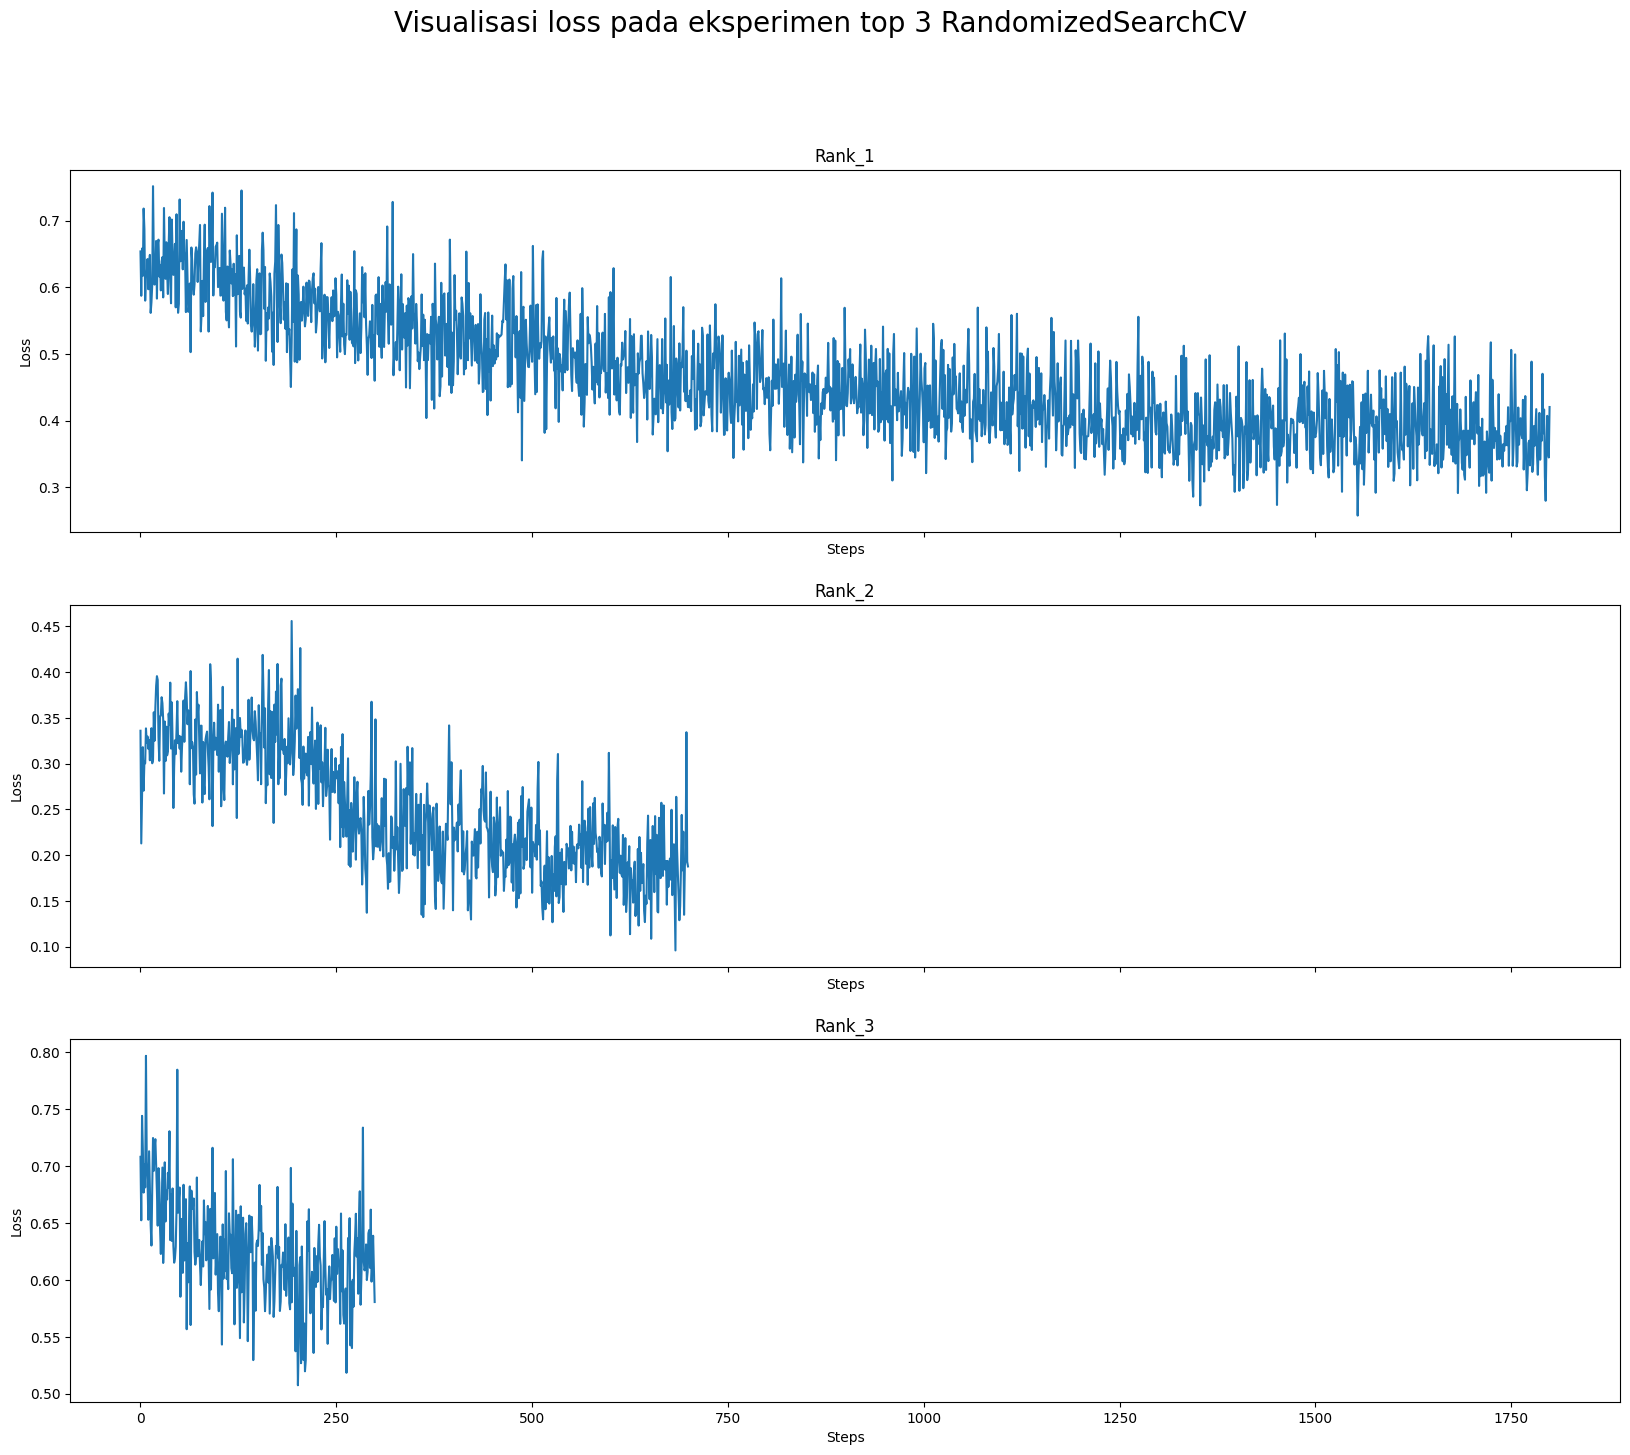

In [140]:
fig, axs = plt.subplots(3, sharex=True, figsize=(20,16))
fig.suptitle("Visualisasi loss pada eksperimen top 3 RandomizedSearchCV", fontsize=20)
axs[0].plot(range(len(all_losses[2])), all_losses[2])
axs[0].set_title("Rank_1")
axs[1].plot(range(len(all_losses[1])), all_losses[1])
axs[1].set_title("Rank_2")
axs[2].plot(range(len(all_losses[0])), all_losses[0])
axs[2].set_title("Rank_3")

for ax in axs.flat:
  ax.set(xlabel='Steps', ylabel='Loss')

plt.show()

# Visualisasi akurasi model eksperimen

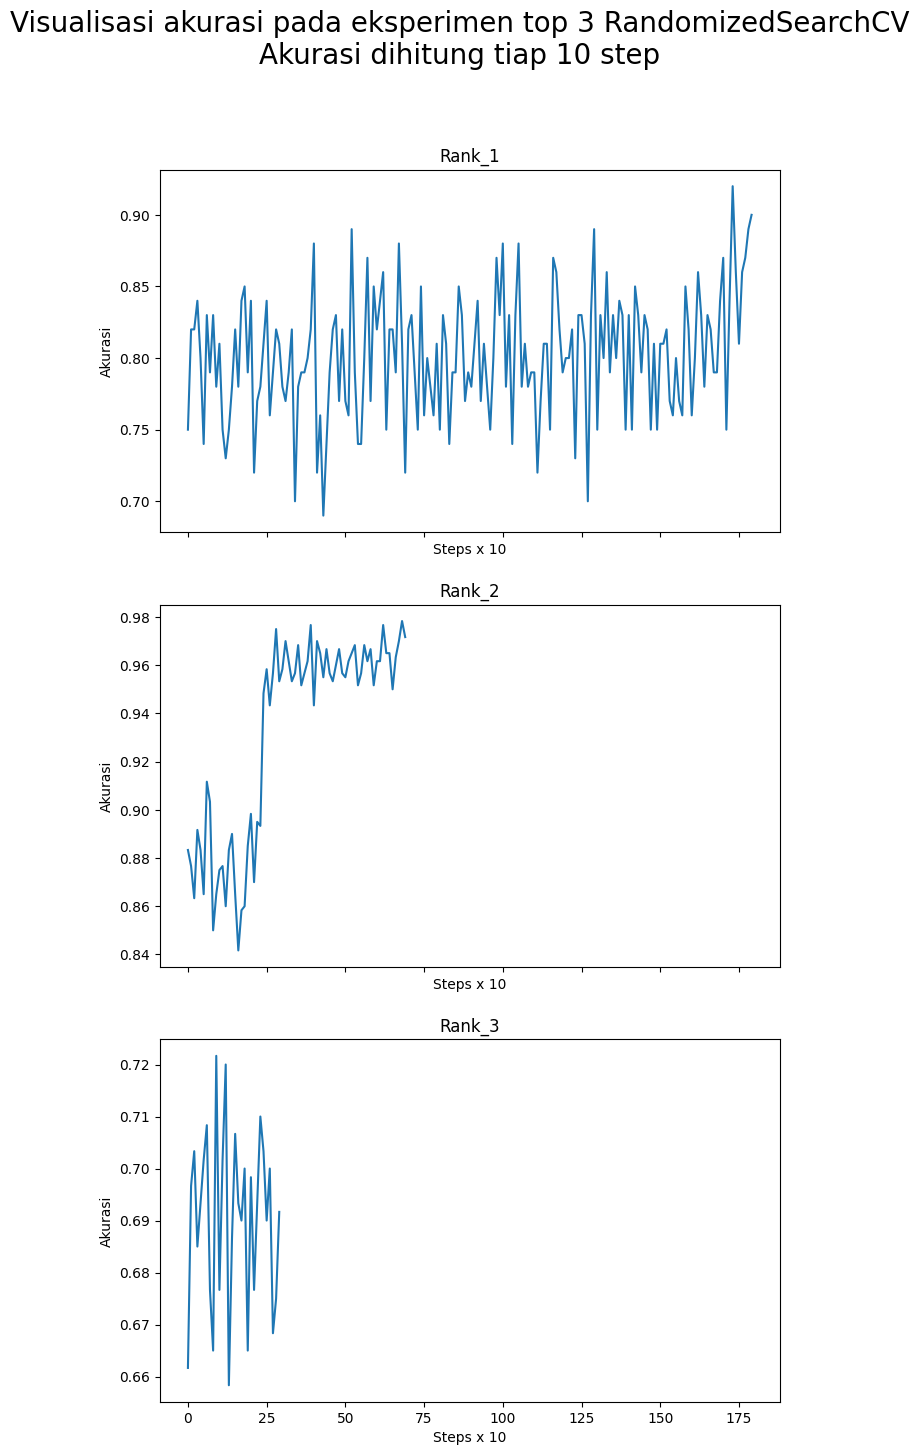

In [142]:
fig, axs = plt.subplots(3, sharex=True, figsize=(8,16))
fig.suptitle("Visualisasi akurasi pada eksperimen top 3 RandomizedSearchCV\nAkurasi dihitung tiap 10 step", fontsize=20)
axs[0].plot(range(len(all_accuracies[2])), all_accuracies[2])
axs[0].set_title("Rank_1")
axs[1].plot(range(len(all_accuracies[1])), all_accuracies[1])
axs[1].set_title("Rank_2")
axs[2].plot(range(len(all_accuracies[0])), all_accuracies[0])
axs[2].set_title("Rank_3")

for ax in axs.flat:
  ax.set(xlabel='Steps x 10', ylabel='Akurasi')

plt.show()

# Pelatihan model yunjey dengan MyNet dan visualisasi loss dan akurasi

In [144]:
model_yunjey = MyNet(784, 500, 1, nn.ReLU, 10, softmax=False).to(device)
losses_yj, accuracies_yj = (train_and_test(model_yunjey, 5, 100, 0.001))

MyNet(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): Linear(in_features=500, out_features=10, bias=True)
  )
)
Epoch [1/5], Step [100/600], Loss: 0.3209
Epoch [1/5], Step [200/600], Loss: 0.1358
Epoch [1/5], Step [300/600], Loss: 0.2497
Epoch [1/5], Step [400/600], Loss: 0.1284
Epoch [1/5], Step [500/600], Loss: 0.0931
Epoch [1/5], Step [600/600], Loss: 0.1028
Epoch [2/5], Step [100/600], Loss: 0.1229
Epoch [2/5], Step [200/600], Loss: 0.2337
Epoch [2/5], Step [300/600], Loss: 0.1510
Epoch [2/5], Step [400/600], Loss: 0.0834
Epoch [2/5], Step [500/600], Loss: 0.0464
Epoch [2/5], Step [600/600], Loss: 0.1875
Epoch [3/5], Step [100/600], Loss: 0.0314
Epoch [3/5], Step [200/600], Loss: 0.0785
Epoch [3/5], Step [300/600], Loss: 0.0480
Epoch [3/5], Step [400/600], Loss: 0.0492
Epoch [3/5], Step [500/600], Loss: 0.1129
Epoch [3/5], Step [600/600], Loss: 0.1100
Epoch 

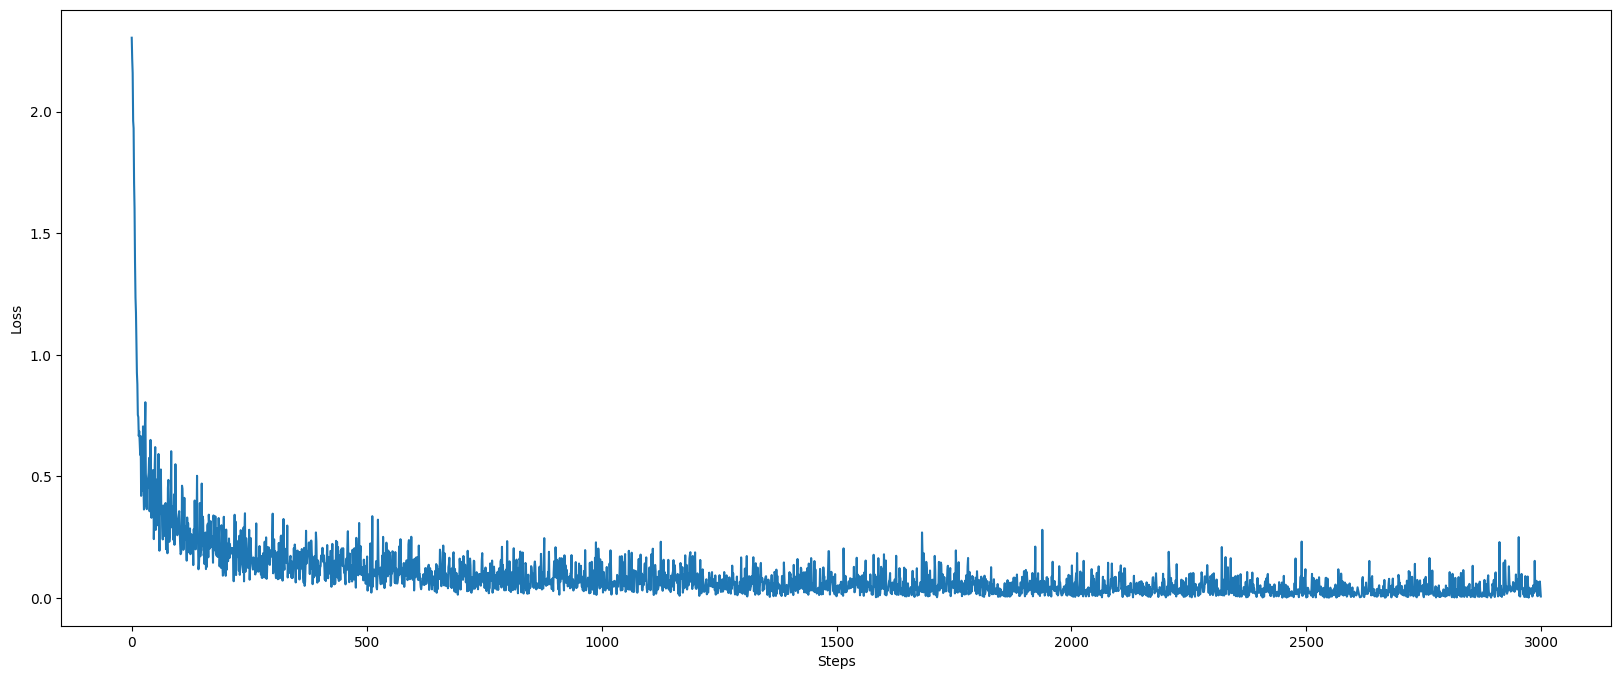

In [145]:
# Plotting penghitungan loss dari model contoh oleh yunjey dengan kelas MyNet
plt.figure(figsize=(20,8))
plt.plot(range(3000), losses_yj)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

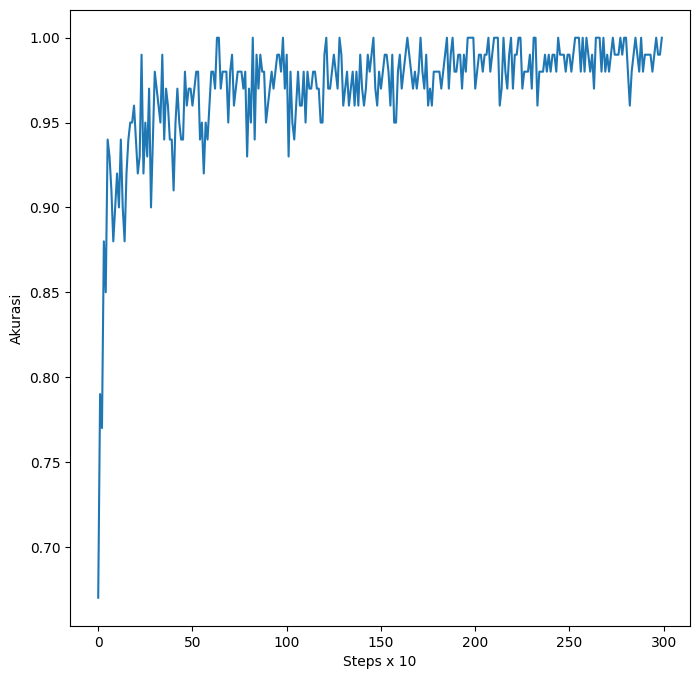

In [146]:
# Plotting penghitungan akurasi dari model contoh oleh yunjey dengan kelas MyNet
plt.figure(figsize=(8,8))
plt.plot(range(300), accuracies_yj)
plt.xlabel("Steps x 10")
plt.ylabel("Akurasi")
plt.show()

# Eksperimen lanjut


In [104]:
exp = []
exp.append(MyNet(784, 600, 1, nn.LeakyReLU, 10).to(device))
exp.append(MyNet(784, 600, 1, nn.Sigmoid, 10).to(device))
exp.append(MyNet(784, 600, 1, nn.LeakyReLU, 10, softmax=False).to(device))
exp.append(MyNet(784, 600, 1, nn.Sigmoid, 10, softmax=False).to(device))

In [106]:
all_losses = []
all_accuracies = []

losses, accuracies = (train_and_test(exp[0], 7, 600, 0.01))
all_losses.append(losses)
all_accuracies.append(accuracies)
losses, accuracies = (train_and_test(exp[1], 7, 600, 0.01))
all_losses.append(losses)
all_accuracies.append(accuracies)
losses, accuracies = (train_and_test(exp[2], 7, 600, 0.01))
all_losses.append(losses)
all_accuracies.append(accuracies)
losses, accuracies = (train_and_test(exp[3], 7, 600, 0.01))
all_losses.append(losses)
all_accuracies.append(accuracies)

Epoch [1/7], Step [100/100], Loss: 0.6467
Epoch [2/7], Step [100/100], Loss: 0.5067
Epoch [3/7], Step [100/100], Loss: 0.3984
Epoch [4/7], Step [100/100], Loss: 0.1704
Epoch [5/7], Step [100/100], Loss: 0.0978
Epoch [6/7], Step [100/100], Loss: 0.1217
Epoch [7/7], Step [100/100], Loss: 0.0758
Accuracy of the network on the 10000 test images: 96.32 %
Epoch [1/7], Step [100/100], Loss: 1.1159
Epoch [2/7], Step [100/100], Loss: 0.9594
Epoch [3/7], Step [100/100], Loss: 0.7355
Epoch [4/7], Step [100/100], Loss: 0.5978
Epoch [5/7], Step [100/100], Loss: 0.4108
Epoch [6/7], Step [100/100], Loss: 0.3543
Epoch [7/7], Step [100/100], Loss: 0.2997
Accuracy of the network on the 10000 test images: 87.73 %
Epoch [1/7], Step [100/100], Loss: 0.0825
Epoch [2/7], Step [100/100], Loss: 0.0717
Epoch [3/7], Step [100/100], Loss: 0.0477
Epoch [4/7], Step [100/100], Loss: 0.0589
Epoch [5/7], Step [100/100], Loss: 0.0429
Epoch [6/7], Step [100/100], Loss: 0.0729
Epoch [7/7], Step [100/100], Loss: 0.0494
Ac

## Hasil eksperimen lanjut

```
Epoch [1/7], Step [100/100], Loss: 0.6467
Epoch [2/7], Step [100/100], Loss: 0.5067
Epoch [3/7], Step [100/100], Loss: 0.3984
Epoch [4/7], Step [100/100], Loss: 0.1704
Epoch [5/7], Step [100/100], Loss: 0.0978
Epoch [6/7], Step [100/100], Loss: 0.1217
Epoch [7/7], Step [100/100], Loss: 0.0758
Accuracy of the network on the 10000 test images: 96.32 %
Epoch [1/7], Step [100/100], Loss: 1.1159
Epoch [2/7], Step [100/100], Loss: 0.9594
Epoch [3/7], Step [100/100], Loss: 0.7355
Epoch [4/7], Step [100/100], Loss: 0.5978
Epoch [5/7], Step [100/100], Loss: 0.4108
Epoch [6/7], Step [100/100], Loss: 0.3543
Epoch [7/7], Step [100/100], Loss: 0.2997
Accuracy of the network on the 10000 test images: 87.73 %
Epoch [1/7], Step [100/100], Loss: 0.0825
Epoch [2/7], Step [100/100], Loss: 0.0717
Epoch [3/7], Step [100/100], Loss: 0.0477
Epoch [4/7], Step [100/100], Loss: 0.0589
Epoch [5/7], Step [100/100], Loss: 0.0429
Epoch [6/7], Step [100/100], Loss: 0.0729
Epoch [7/7], Step [100/100], Loss: 0.0494
Accuracy of the network on the 10000 test images: 96.95 %
Epoch [1/7], Step [100/100], Loss: 0.2421
Epoch [2/7], Step [100/100], Loss: 0.1565
Epoch [3/7], Step [100/100], Loss: 0.0938
Epoch [4/7], Step [100/100], Loss: 0.0539
Epoch [5/7], Step [100/100], Loss: 0.0367
Epoch [6/7], Step [100/100], Loss: 0.0236
Epoch [7/7], Step [100/100], Loss: 0.0232
Accuracy of the network on the 10000 test images: 97.33 %
```

In [121]:
print(exp[3])

MyNet(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Linear(in_features=100, out_features=10, bias=True)
  )
)


# Visualisasi loss model eksperimen lanjut

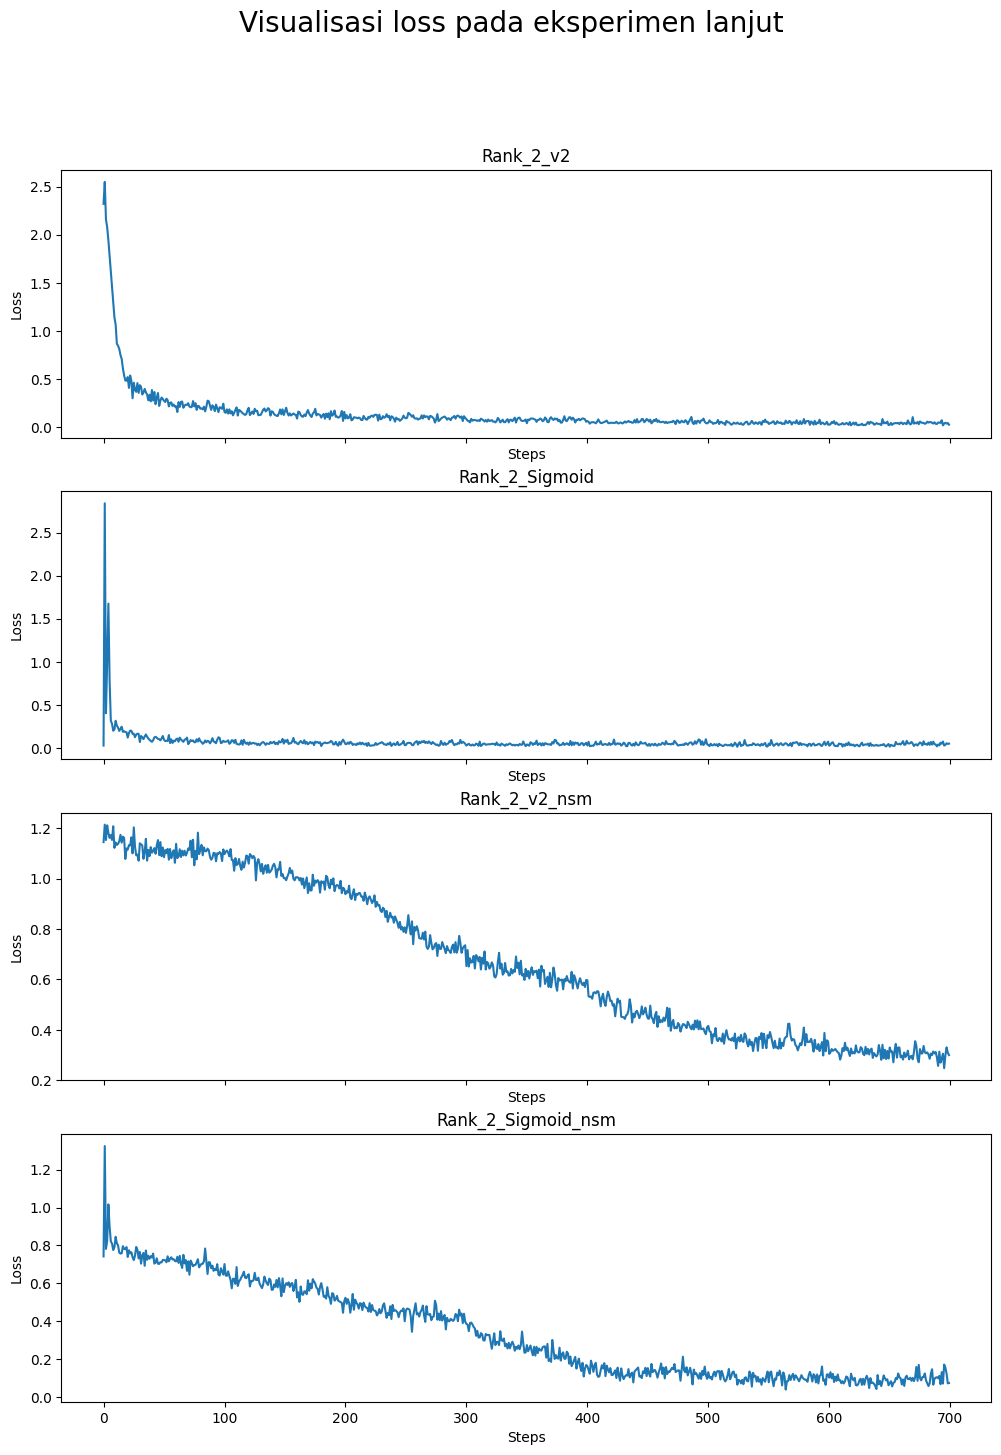

In [122]:
fig, axs = plt.subplots(4, sharex=True, figsize=(12,16))
fig.suptitle("Visualisasi loss pada eksperimen lanjut", fontsize=20)
axs[0].plot(range(len(all_losses[3])), all_losses[3])
axs[0].set_title("Rank_2_v2")
axs[1].plot(range(len(all_losses[2])), all_losses[2])
axs[1].set_title("Rank_2_Sigmoid")
axs[2].plot(range(len(all_losses[1])), all_losses[1])
axs[2].set_title("Rank_2_v2_nsm")
axs[3].plot(range(len(all_losses[0])), all_losses[0])
axs[3].set_title("Rank_2_Sigmoid_nsm")

for ax in axs.flat:
  ax.set(xlabel='Steps', ylabel='Loss')

plt.show()

# Visualisasi akurasi model eksperimen lanjut

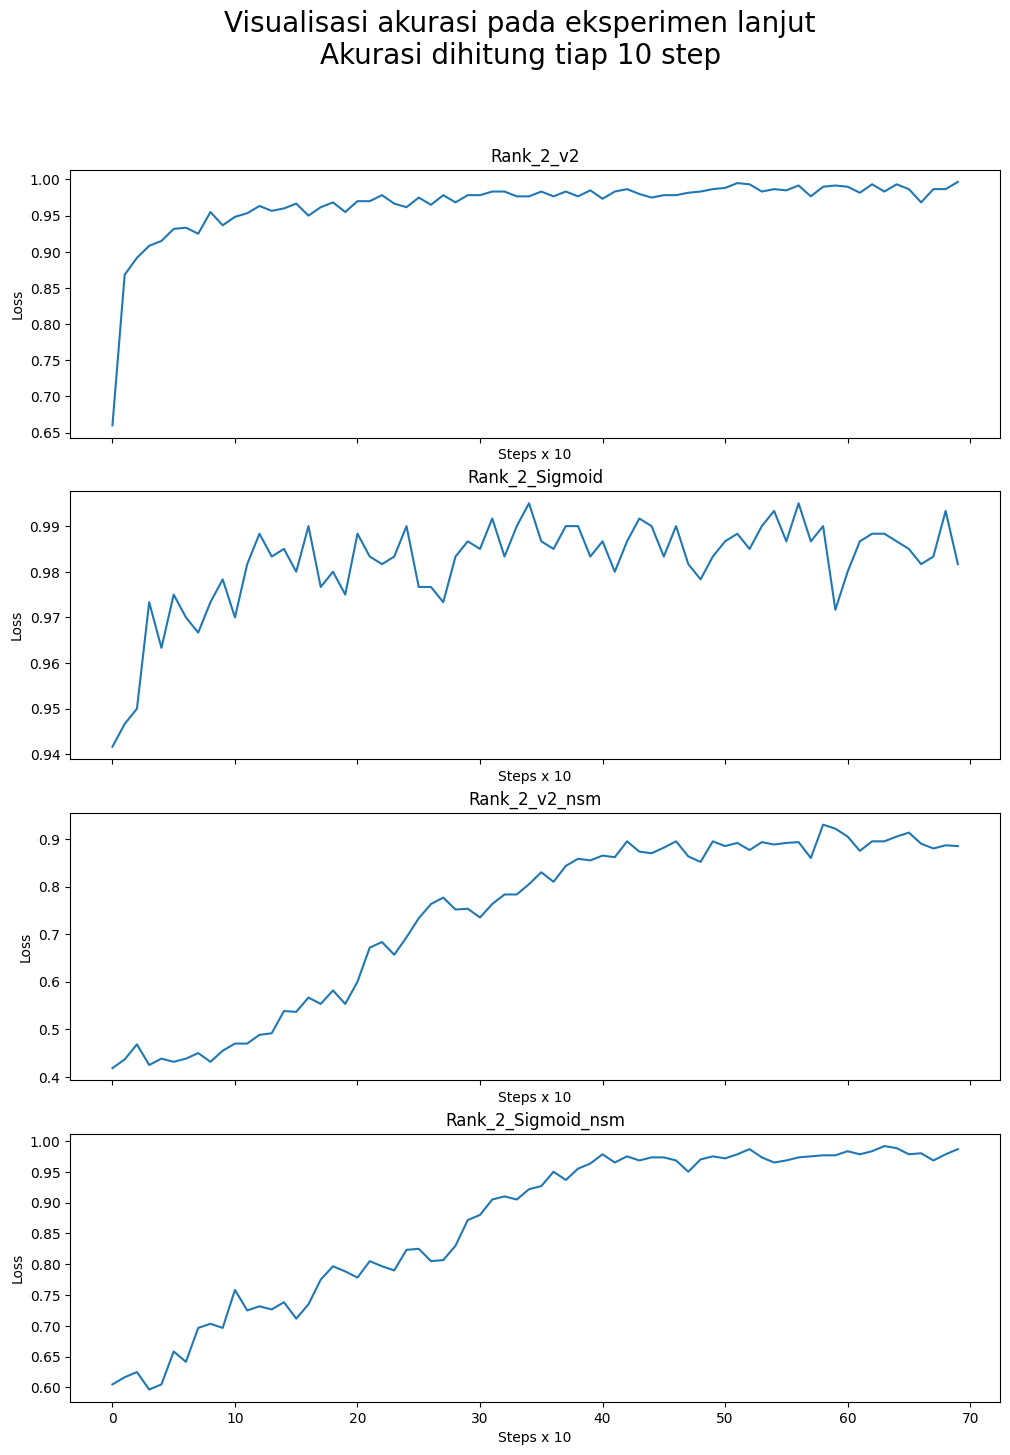

In [123]:
fig, axs = plt.subplots(4, sharex=True, figsize=(12,16))
fig.suptitle("Visualisasi akurasi pada eksperimen lanjut\nAkurasi dihitung tiap 10 step", fontsize=20)
axs[0].plot(range(len(all_accuracies[3])), all_accuracies[3])
axs[0].set_title("Rank_2_v2")
axs[1].plot(range(len(all_accuracies[2])), all_accuracies[2])
axs[1].set_title("Rank_2_Sigmoid")
axs[2].plot(range(len(all_accuracies[1])), all_accuracies[1])
axs[2].set_title("Rank_2_v2_nsm")
axs[3].plot(range(len(all_accuracies[0])), all_accuracies[0])
axs[3].set_title("Rank_2_Sigmoid_nsm")

for ax in axs.flat:
  ax.set(xlabel='Steps x 10', ylabel='Loss')

plt.show()